In [1]:
!cp /kaggle/input/setupfiles/environment.yml /kaggle/working/
!cp /kaggle/input/setupfiles/install.sh /kaggle/working/

!bash install.sh

Installing dependencies from environment.yml using pip...
Environment setup completed successfully!


In [2]:
import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch import optim

import os
import numpy as np
import seaborn as sns
import pandas as pd

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_curve,auc,accuracy_score
from sklearn.preprocessing import label_binarize

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class Config:
    TRAIN_DIR =  '/kaggle/input/identify-the-birds/Birds/train'
    VAL_DIR = ''
    CLASS_NAME = sorted(os.listdir(TRAIN_DIR))
    N_CLASS = len(CLASS_NAME)
    IMG_SIZE = 224
    BATCH_SIZE = 128
    LR = 0.001
    EPOCHS = 30

In [4]:
transform = T.Compose([
    T.Resize((Config.IMG_SIZE,Config.IMG_SIZE)),
    T.RandomAutocontrast(0.2),
    T.CenterCrop((Config.IMG_SIZE,Config.IMG_SIZE)),
    T.ToTensor()
])

In [5]:
train_dir = '/kaggle/input/identify-the-birds/Birds/train'
full_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Define the split ratio (e.g., 80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
def Load_Model_to_GPU(model):
    if torch.cuda.device_count() > 1:
        print('Using {} GPUs!'.format(torch.cuda.device_count()))
        
        model = nn.DataParallel(model)
        return model
    else:
        model = model.to(device)
        return model

8


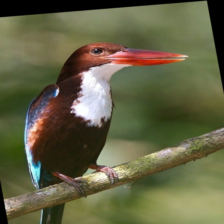

In [7]:
image,labels = train_dataset[2]
print(Config.CLASS_NAME[labels])
T.ToPILImage()(image)

In [8]:
class CustomConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size: int, padding: str | int, stride=1, activation=True):
        super(CustomConv, self).__init__()

        self.activation = activation
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.norm = nn.BatchNorm2d(out_channels)
        self.active = nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.norm(x)

        if self.activation:
            x = self.active(x)
        return x
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_stride=1):
        super(ResidualBlock, self).__init__()

        self.dotted = (n_stride != 1) or (in_channels != out_channels * 4)

        self.conv_1 = CustomConv(in_channels, out_channels, 1, 0, n_stride)
        self.conv_2 = CustomConv(out_channels, out_channels, 3, 'same')
        self.conv_3 = CustomConv(out_channels, out_channels * 4, 1, 'same')

        if self.dotted:
            self.conv_e = CustomConv(in_channels, out_channels * 4, 1, 0, n_stride, activation=False)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.conv_3(x)

        if self.dotted:
            x_add = self.conv_e(inputs)
        else:
            x_add = inputs
        
        x_add = x + x_add
        
        return x_add
class ResNet50(nn.Module):
    def __init__(self, N_CLASS):
        super(ResNet50, self).__init__()

        self.conv_7 = CustomConv(3, 64, 7, 3, 2)
        self.max_pool = nn.MaxPool2d(3, 2)

        self.conv_1_1 = ResidualBlock(64, 64)
        self.conv_1_2 = ResidualBlock(256, 64)
        self.conv_1_3 = ResidualBlock(256, 64)
        
        self.dropout_1 = nn.Dropout(0.2)
        
        self.conv_2_1 = ResidualBlock(256, 128, 2)
        self.conv_2_2 = ResidualBlock(512, 128)
        self.conv_2_3 = ResidualBlock(512, 128)
        self.conv_2_4 = ResidualBlock(512, 128)
        
        self.dropout_2 = nn.Dropout(0.2)
        
        self.conv_3_1 = ResidualBlock(512, 256, 2)
        self.conv_3_2 = ResidualBlock(1024, 256)
        self.conv_3_3 = ResidualBlock(1024, 256)
        self.conv_3_4 = ResidualBlock(1024, 256)
        self.conv_3_5 = ResidualBlock(1024, 256)
        self.conv_3_6 = ResidualBlock(1024, 256)
        
        self.dropout_3 = nn.Dropout(0.2)
        
        self.conv_4_1 = ResidualBlock(1024, 512, 2)
        self.conv_4_2 = ResidualBlock(2048, 512)
        self.conv_4_3 = ResidualBlock(2048, 512)
        
        self.dropout_4 = nn.Dropout(0.2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        self.flatten = nn.Flatten()
        
        self.dropout_5 = nn.Dropout(0.2)
        
        self.fc = nn.Linear(2048, N_CLASS)
    
    def forward(self, x):

        x = self.conv_7(x)
        x = self.max_pool(x)

        x = self.conv_1_1(x)
        x = self.conv_1_2(x)
        x = self.conv_1_3(x)
        
        x = self.dropout_1(x)
        
        x = self.conv_2_1(x)
        x = self.conv_2_2(x)
        x = self.conv_2_3(x)
        x = self.conv_2_4(x)
        
        x = self.dropout_2(x)
        
        x = self.conv_3_1(x)
        x = self.conv_3_2(x)
        x = self.conv_3_3(x)
        x = self.conv_3_4(x)
        x = self.conv_3_5(x)
        x = self.conv_3_6(x)

        x = self.dropout_3(x)
        
        x = self.conv_4_1(x)
        x = self.conv_4_2(x)
        x = self.conv_4_3(x)
        
        x = self.dropout_4(x)
        
        x = self.avg_pool(x)
        x = self.flatten(x)
        
        x = self.dropout_5(x)
        
        x = self.fc(x)

        return x
resnet_model = ResNet50(Config.N_CLASS)
resnet_model = Load_Model_to_GPU(resnet_model)
summary(resnet_model,(Config.BATCH_SIZE,3,Config.IMG_SIZE,Config.IMG_SIZE))

Using 2 GPUs!


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [128, 10]                 --
├─ResNet50: 1-1                          [64, 10]                  --
├─ResNet50: 1-4                          --                        (recursive)
│    └─CustomConv: 2-1                   [64, 64, 112, 112]        --
│    └─CustomConv: 2-4                   --                        (recursive)
│    │    └─Conv2d: 3-1                  [64, 64, 112, 112]        --
├─ResNet50: 1-3                          [64, 10]                  23,555,082
├─ResNet50: 1-4                          --                        (recursive)
│    └─CustomConv: 2-3                   [64, 64, 112, 112]        9,600
│    └─CustomConv: 2-4                   --                        (recursive)
│    │    └─Conv2d: 3-2                  [64, 64, 112, 112]        9,472
│    │    └─BatchNorm2d: 3-3             [64, 64, 112, 112]        128
│    │    └─BatchNorm2d: 3-4      

In [9]:
def train(model, train_loader, optim, loss_fn):
    model.train()
    running_loss = 0
    all_labels = []
    all_predictions = []

    for _, (image, labels) in enumerate(tqdm(train_loader, leave=False)):
        image, labels = image.to(device), labels.to(device)
        
        optim.zero_grad()
        
        pred = model(image)
        loss = loss_fn(pred, labels)
        
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        prediction = pred.argmax(dim=1)

        # Accumulate predictions and labels for metric calculations
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(prediction.cpu().numpy())
    
    # Calculate metrics at the end of the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_predictions)
    epoch_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    # Append to metrics dictionary
    metrics['accuracy'].append(epoch_acc)
    metrics['loss'].append(epoch_loss)
    metrics['precision'].append(epoch_precision)
    metrics['recall'].append(epoch_recall)
    
    print(f'|| Training Loss = {epoch_loss:0.4f} || Accuracy = {epoch_acc:0.4f} || Precision = {epoch_precision:0.4f} || Recall = {epoch_recall:0.4f} ||')


def valid(model, val_loader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for image, labels in val_loader:
            image, labels = image.to(device), labels.to(device)
            output = model(image)
            
            val_loss += F.cross_entropy(output, labels, reduction='sum').item()
            pred = output.argmax(dim=1)

            # Accumulate predictions and labels for metric calculations
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(pred.cpu().numpy())
    
    # Calculate metrics at the end of validation
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(all_labels, all_predictions)
    val_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    val_recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    # Append to metrics dictionary
    metrics['val_accuracy'].append(val_acc)
    metrics['val_loss'].append(avg_val_loss)
    metrics['val_precision'].append(val_precision)
    metrics['val_recall'].append(val_recall)
    
    print(f'|| Validation Loss = {avg_val_loss:0.4f} || Validation Accuracy = {val_acc:0.4f} || Validation Precision = {val_precision:0.4f} || Validation Recall = {val_recall:0.4f} ||')

In [10]:
resnet_optim = optim.NAdam(resnet_model.parameters(),lr=Config.LR)
loss_fn = nn.CrossEntropyLoss()
metrics = {'accuracy':[],'val_accuracy':[],
           'loss':[],'val_loss':[],
           'precision':[],'val_precision':[],
           'recall':[],'val_recall':[]}

In [11]:
for epoch in range(Config.EPOCHS):
    print(f'|| Epoch : [{epoch+1}/{Config.EPOCHS}] ||')
    train(resnet_model,train_dataloader,resnet_optim,loss_fn)
    valid(resnet_model,test_dataloader)

|| Epoch : [1/30] ||


|| Training Loss = 1.7388 || Accuracy = 0.4075 || Precision = 0.4108 || Recall = 0.4075 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 1.6980 || Validation Accuracy = 0.4313 || Validation Precision = 0.5310 || Validation Recall = 0.4313 ||
|| Epoch : [2/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 1.1715 || Accuracy = 0.5756 || Precision = 0.5783 || Recall = 0.5756 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 1.4858 || Validation Accuracy = 0.5479 || Validation Precision = 0.5923 || Validation Recall = 0.5479 ||
|| Epoch : [3/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.9479 || Accuracy = 0.6765 || Precision = 0.6798 || Recall = 0.6765 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 1.3914 || Validation Accuracy = 0.5026 || Validation Precision = 0.6330 || Validation Recall = 0.5026 ||
|| Epoch : [4/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.7279 || Accuracy = 0.7598 || Precision = 0.7645 || Recall = 0.7598 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.9421 || Validation Accuracy = 0.6917 || Validation Precision = 0.7392 || Validation Recall = 0.6917 ||
|| Epoch : [5/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.5890 || Accuracy = 0.8048 || Precision = 0.8079 || Recall = 0.8048 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 1.4258 || Validation Accuracy = 0.5583 || Validation Precision = 0.7354 || Validation Recall = 0.5583 ||
|| Epoch : [6/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.5256 || Accuracy = 0.8257 || Precision = 0.8283 || Recall = 0.8257 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.8697 || Validation Accuracy = 0.7391 || Validation Precision = 0.7705 || Validation Recall = 0.7391 ||
|| Epoch : [7/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.4562 || Accuracy = 0.8533 || Precision = 0.8554 || Recall = 0.8533 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 2.4098 || Validation Accuracy = 0.5594 || Validation Precision = 0.6848 || Validation Recall = 0.5594 ||
|| Epoch : [8/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.3832 || Accuracy = 0.8730 || Precision = 0.8750 || Recall = 0.8730 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.6149 || Validation Accuracy = 0.7745 || Validation Precision = 0.8184 || Validation Recall = 0.7745 ||
|| Epoch : [9/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.3397 || Accuracy = 0.8873 || Precision = 0.8892 || Recall = 0.8873 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.6701 || Validation Accuracy = 0.7849 || Validation Precision = 0.8080 || Validation Recall = 0.7849 ||
|| Epoch : [10/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.3039 || Accuracy = 0.8965 || Precision = 0.8979 || Recall = 0.8965 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.8915 || Validation Accuracy = 0.7344 || Validation Precision = 0.8003 || Validation Recall = 0.7344 ||
|| Epoch : [11/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.2497 || Accuracy = 0.9158 || Precision = 0.9168 || Recall = 0.9158 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.7169 || Validation Accuracy = 0.7932 || Validation Precision = 0.8263 || Validation Recall = 0.7932 ||
|| Epoch : [12/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.2380 || Accuracy = 0.9223 || Precision = 0.9234 || Recall = 0.9223 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.7418 || Validation Accuracy = 0.7911 || Validation Precision = 0.8217 || Validation Recall = 0.7911 ||
|| Epoch : [13/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.1932 || Accuracy = 0.9322 || Precision = 0.9327 || Recall = 0.9322 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.7344 || Validation Accuracy = 0.7786 || Validation Precision = 0.8107 || Validation Recall = 0.7786 ||
|| Epoch : [14/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.1861 || Accuracy = 0.9384 || Precision = 0.9388 || Recall = 0.9384 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 1.1463 || Validation Accuracy = 0.7318 || Validation Precision = 0.7889 || Validation Recall = 0.7318 ||
|| Epoch : [15/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.1797 || Accuracy = 0.9399 || Precision = 0.9404 || Recall = 0.9399 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 1.5949 || Validation Accuracy = 0.6359 || Validation Precision = 0.7505 || Validation Recall = 0.6359 ||
|| Epoch : [16/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.1516 || Accuracy = 0.9490 || Precision = 0.9492 || Recall = 0.9490 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.6559 || Validation Accuracy = 0.8151 || Validation Precision = 0.8386 || Validation Recall = 0.8151 ||
|| Epoch : [17/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.1264 || Accuracy = 0.9556 || Precision = 0.9559 || Recall = 0.9556 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.6571 || Validation Accuracy = 0.8104 || Validation Precision = 0.8391 || Validation Recall = 0.8104 ||
|| Epoch : [18/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.1259 || Accuracy = 0.9561 || Precision = 0.9563 || Recall = 0.9561 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.6997 || Validation Accuracy = 0.8297 || Validation Precision = 0.8473 || Validation Recall = 0.8297 ||
|| Epoch : [19/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0979 || Accuracy = 0.9669 || Precision = 0.9670 || Recall = 0.9669 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.9631 || Validation Accuracy = 0.8031 || Validation Precision = 0.8314 || Validation Recall = 0.8031 ||
|| Epoch : [20/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0891 || Accuracy = 0.9710 || Precision = 0.9711 || Recall = 0.9710 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.8153 || Validation Accuracy = 0.8156 || Validation Precision = 0.8367 || Validation Recall = 0.8156 ||
|| Epoch : [21/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.1050 || Accuracy = 0.9648 || Precision = 0.9649 || Recall = 0.9648 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.7021 || Validation Accuracy = 0.8187 || Validation Precision = 0.8349 || Validation Recall = 0.8187 ||
|| Epoch : [22/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0842 || Accuracy = 0.9709 || Precision = 0.9710 || Recall = 0.9709 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.7608 || Validation Accuracy = 0.8385 || Validation Precision = 0.8585 || Validation Recall = 0.8385 ||
|| Epoch : [23/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0723 || Accuracy = 0.9773 || Precision = 0.9774 || Recall = 0.9773 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 1.0101 || Validation Accuracy = 0.7990 || Validation Precision = 0.8302 || Validation Recall = 0.7990 ||
|| Epoch : [24/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0663 || Accuracy = 0.9790 || Precision = 0.9790 || Recall = 0.9790 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 1.1968 || Validation Accuracy = 0.7870 || Validation Precision = 0.8163 || Validation Recall = 0.7870 ||
|| Epoch : [25/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0536 || Accuracy = 0.9831 || Precision = 0.9831 || Recall = 0.9831 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.9113 || Validation Accuracy = 0.8198 || Validation Precision = 0.8440 || Validation Recall = 0.8198 ||
|| Epoch : [26/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0710 || Accuracy = 0.9757 || Precision = 0.9757 || Recall = 0.9757 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.6146 || Validation Accuracy = 0.8510 || Validation Precision = 0.8601 || Validation Recall = 0.8510 ||
|| Epoch : [27/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0474 || Accuracy = 0.9839 || Precision = 0.9839 || Recall = 0.9839 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.8109 || Validation Accuracy = 0.8156 || Validation Precision = 0.8481 || Validation Recall = 0.8156 ||
|| Epoch : [28/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0602 || Accuracy = 0.9786 || Precision = 0.9786 || Recall = 0.9786 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.7059 || Validation Accuracy = 0.8375 || Validation Precision = 0.8487 || Validation Recall = 0.8375 ||
|| Epoch : [29/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0797 || Accuracy = 0.9742 || Precision = 0.9742 || Recall = 0.9742 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.7892 || Validation Accuracy = 0.8172 || Validation Precision = 0.8252 || Validation Recall = 0.8172 ||
|| Epoch : [30/30] ||


  0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Training Loss = 0.0781 || Accuracy = 0.9749 || Precision = 0.9749 || Recall = 0.9749 ||


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|| Validation Loss = 0.8281 || Validation Accuracy = 0.8234 || Validation Precision = 0.8554 || Validation Recall = 0.8234 ||
